# Practical Work 01 - Minimum Circle

| Information | Details     |
| ----------- | ----------- |
| Course      | Computational Geometry (`INF2604`) |
| Professor   | Waldemar Celes (<celes@inf.puc-rio.br>) |
| Student     | Gabriel Ribeiro Gomes (<ggomes@inf.puc-rio.br>, <ribeiroggabriel@gmail.com>) |

## Setup and problem definition

We need to generate a report that fulfills the following requirements:

- Define different circles with radius $r$ and center in $(x, y)$.
- Generate a cloud of $n$ randomized points inside of the circle.
- Use the implemented functions to compute the minimum enclosing circle for the generated points:
    - Heuristic algorithm; and
    - Minimum circle algorithm.
- The value of the minimum enclosing circle should be equal or less than the original circle.
- You should notice that the $r$ found by the heuristic algorithm will be larger by a little.
- How the time of the algorithms varies with the number of generated points? We know that:
    - Heuristic algorithm has $O(n)$ time complexity; and
    - Minimum circle has also $O(n)$ time complexity.

## Defining a cloud of randomized points inside a circle

To define a circle, we'll use as inputs:

- A center point defined by $(center_x, center_y)$
- A radius defined by $radius$

We'll create a `Pydantic` model to represent the circle and its properties (and other code models below). This model will include validation to ensure that the generated points fall within the defined circle.

In [1]:
from pydantic import BaseModel, field_validator


class Circle(BaseModel):
    center_x: float
    center_y: float
    radius: float

    @field_validator("radius")
    def radius_must_be_positive(cls, radius_value):
        if radius_value <= 0:
            raise ValueError("Radius must be positive")
        return radius_value


possible_circle = Circle(center_x=10, center_y=10, radius=5)
possible_circle

Circle(center_x=10.0, center_y=10.0, radius=5.0)

Now, having our circle implementation, we need to create a class to setup our simulation. This class will receive the circle and return a cloud of randomized points inside the circle.

To ensure that a point is inside of the circle, the distance between this point and the center should be equal or less than the radius. This can be mathematically represented as:

$$(x - center_x)^2 + (y - center_y)^2 \leq radius^2$$

Where $(x, y)$ are the coordinates of the point.

And, to generate random points inside the circle, we can use the following approach:

1. Generate random polar coordinates $(r, \theta)$, where $r$ is the radius and $\theta$ is the angle.
    - $r$ should be uniformly distributed between $0$ and $radius$.
    - $\theta$ should be uniformly distributed between $0$ and $2\pi$.
2. Convert these polar coordinates to Cartesian coordinates using the formulas:
   - $x = center_x + r \cdot \cos(\theta)$
   - $y = center_y + r \cdot \sin(\theta)$
3. Ensure that the generated point $(x, y)$ satisfies the circle's equation.

For each point, we'll have a `Point` class with the following attributes:

- `x_coordinate`: The x-coordinate of the point.
- `y_coordinate`: The y-coordinate of the point.

Let's implement this in our simulation class.

In [2]:
import math

import numpy as np


class Point(BaseModel):
    """Represents a point in the plane (x, y)"""
    x_coordinate: float
    y_coordinate: float

    def norm(self) -> float:
        """Calculates the Euclidean norm (magnitude) of the point."""
        return math.hypot(self.x_coordinate, self.y_coordinate)


class CircleSimulationData:
    """
    Defines the simulation data for the point cloud generation.

    Parameters:
        circle (Circle): The circle within which to generate points. This is
            fixed for generating the point cloud, whereas the number of points
            generated inside can be parametrized in the class methods.
    """

    def __init__(self, circle: Circle, rng: np.random.Generator | None = None) -> None:
        self.circle = circle
        self.rng = rng or np.random.default_rng()

    def generate_point_cloud(self, n_points: int) -> list[Point]:
        """
        Generates a cloud of random points inside the circle.

        Args:
            n_points (int): The number of points to generate.

        Returns:
            np.array[Point]: An array of Point objects representing the
                generated points.
        """
        points = []
        for _ in range(n_points):

            # `r` being generated as a uniform distribution between 0 and the
            # circle radius should ensure that points are uniformly distributed
            # within the circle.
            r = self.rng.uniform(0, self.circle.radius)
            theta = self.rng.uniform(0, 2 * math.pi)

            x = self.circle.center_x + r * math.cos(theta)
            y = self.circle.center_y + r * math.sin(theta)

            point = Point(x_coordinate=x, y_coordinate=y)
            points.append(point)

        return np.array(points)


# For reproducibility
seed = 45
rng = np.random.default_rng(seed)
n_simulation_points = 70


simulation = CircleSimulationData(circle=possible_circle, rng=rng)
data = simulation.generate_point_cloud(n_points=n_simulation_points)
data[:5]

array([Point(x_coordinate=7.180141190588275, y_coordinate=9.489740219780089),
       Point(x_coordinate=11.443270768046482, y_coordinate=6.4650301686094975),
       Point(x_coordinate=10.467635568545226, y_coordinate=7.492081721423641),
       Point(x_coordinate=6.704310492324462, y_coordinate=7.767660306437511),
       Point(x_coordinate=9.030219205487938, y_coordinate=8.20196615139532)],
      dtype=object)

Now that we have our setup with `Circle`, `Point` and `CircleSimulationData`, let's do a quick visualization to see where we're at.

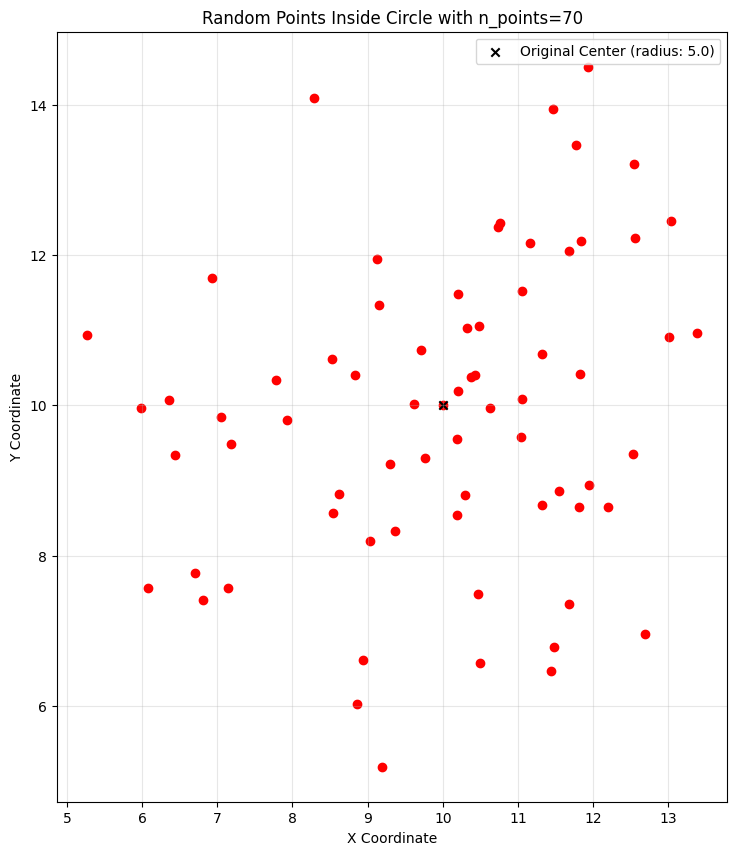

In [3]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

if data is not None:
    x_coords = [point.x_coordinate for point in data]
    y_coords = [point.y_coordinate for point in data]
    ax.scatter(x_coords, y_coords, color='red')

ax.scatter(
    x=possible_circle.center_x,
    y=possible_circle.center_y,
    color='black',
    marker='x',
    label=f"Original Center (radius: {possible_circle.radius})"
)

ax.set_aspect('equal', adjustable='box')

plt.title(f"Random Points Inside Circle with n_points={n_simulation_points}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

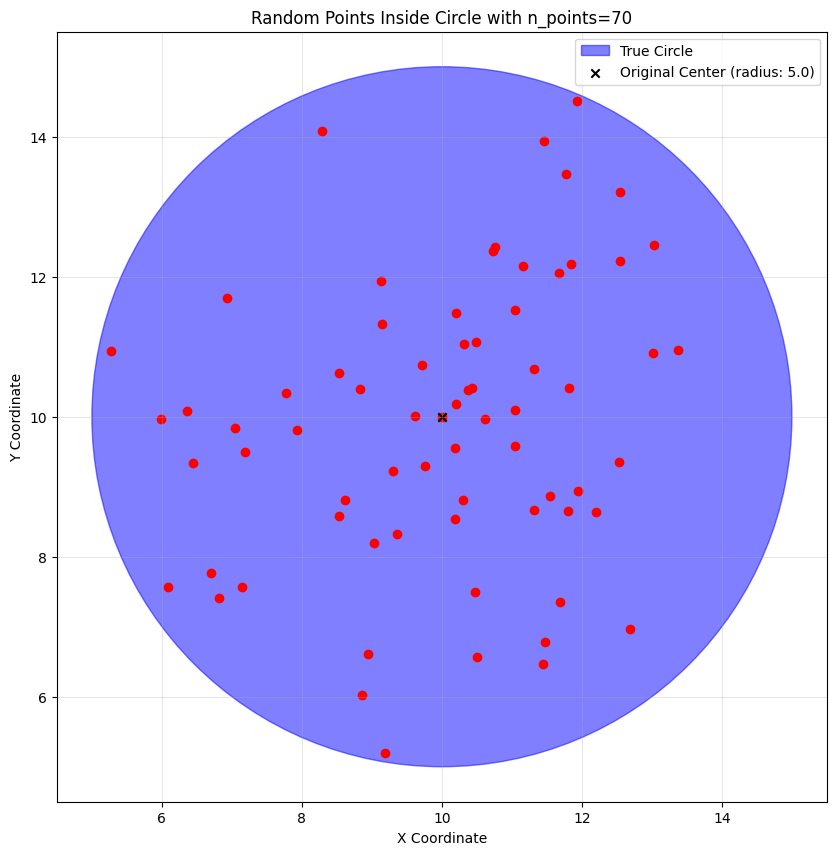

In [4]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

circle_patch = plt.Circle(
    (possible_circle.center_x, possible_circle.center_y),
    possible_circle.radius,
    color='blue',
    alpha=0.5,
    label="True Circle"
)

ax.add_patch(circle_patch)

if data is not None:
    x_coords = [point.x_coordinate for point in data]
    y_coords = [point.y_coordinate for point in data]
    ax.scatter(x_coords, y_coords, color='red')

ax.scatter(
    x=possible_circle.center_x,
    y=possible_circle.center_y,
    color='black',
    marker='x',
    label=f"Original Center (radius: {possible_circle.radius})"
)

ax.set_aspect('equal', adjustable='box')

plt.title(f"Random Points Inside Circle with n_points={n_simulation_points}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Heuristic Algorithm

For the implementation of the heuristic algorithm, we know that:

- It does not result on the minimum circle; but
- Is used as a simple way of determining the enclosing circle for a set of points.

From the slides, we can derive the following pseudo-algorithm:

```pseudo
function heuristic_algorithm:

    px = find the pair of points with px_min and px_max
    py = find the pair of points with py_min and py_max
    # px = [px_min, px_max]
    # py = [py_min, py_max]

    distance_px = distance(px[0], px[1])
    distance_py = distance(py[0], py[1])

    # checks for the larger distance
    if distance_px > distance_py:
        # use px to create the enclosing circle
        center = px[0] + px[1]/2
        radius = distance_px / 2

    else:
        # use py to create the enclosing circle
        center = py[0] + py[1]/2
        radius = distance_py / 2

    for each point:
        distance = point - center
        distance_norm = distance.norm()

        if distance_norm > radius:
            # point is outside the circle
            # update the circle to enclose this point
            center = center + (distance_norm - radius)/2 * (distance/distance_norm)
            radius = (radius + distance(center, point))/2

    return circle, radius
```

We can also see that we're using a `distance` helper function. We'll implement that before as a helper for the algorithms.

In [5]:
def distance_between_two_points(p1: Point, p2: Point) -> float:
    """Calculates the Euclidean distance between two points."""
    return math.hypot(
        p1.x_coordinate - p2.x_coordinate,
        p1.y_coordinate - p2.y_coordinate
    )

In [6]:
def heuristic_algorithm(data: list[Point]) -> Circle:
    """
    A simple heuristic algorithm to find a minimum enclosing circle.

    It calculates the most distant pairs in x and y to define a starting point
    and then iterates through the remaining points on the list to update the circle.

    Args:
        data (list[Point]): The list of points to enclose.

    Returns:
        Circle: The computed minimum enclosing circle.
    """

    min_x_point: Point = Point(x_coordinate=np.inf, y_coordinate=np.inf)
    max_x_point: Point = Point(x_coordinate=-np.inf, y_coordinate=-np.inf)
    min_y_point: Point = Point(x_coordinate=np.inf, y_coordinate=np.inf)
    max_y_point: Point = Point(x_coordinate=-np.inf, y_coordinate=-np.inf)

    for point in data:
        if min_x_point is None or point.x_coordinate < min_x_point.x_coordinate:
            min_x_point = point
        if max_x_point is None or point.x_coordinate > max_x_point.x_coordinate:
            max_x_point = point
        if min_y_point is None or point.y_coordinate < min_y_point.y_coordinate:
            min_y_point = point
        if max_y_point is None or point.y_coordinate > max_y_point.y_coordinate:
            max_y_point = point

    distance_x = distance_between_two_points(min_x_point, max_x_point)
    distance_y = distance_between_two_points(min_y_point, max_y_point)

    if distance_x > distance_y:
        radius = distance_x / 2
        center = Point(
            x_coordinate=(min_x_point.x_coordinate + max_x_point.x_coordinate) / 2,
            y_coordinate=(min_x_point.y_coordinate + max_x_point.y_coordinate) / 2,
        )
    else:
        radius = distance_y / 2
        center = Point(
            x_coordinate=(min_y_point.x_coordinate + max_y_point.x_coordinate) / 2,
            y_coordinate=(min_y_point.y_coordinate + max_y_point.y_coordinate) / 2,
        )

    for point in data:
        distance_vector = Point(
            x_coordinate=point.x_coordinate - center.x_coordinate,
            y_coordinate=point.y_coordinate - center.y_coordinate
        )
        distance_vector_norm = distance_vector.norm()

        if distance_vector_norm > radius:

            update_x = distance_vector.x_coordinate / distance_vector_norm
            update_y = distance_vector.y_coordinate / distance_vector_norm

            alpha = (distance_vector_norm - radius) / 2.0

            center = Point(
                x_coordinate=center.x_coordinate + alpha * update_x,
                y_coordinate=center.y_coordinate + alpha * update_y
            )

            radius = radius + alpha

    return Circle(
        center_x=center.x_coordinate,
        center_y=center.y_coordinate,
        radius=radius
    )


heuristic_circle = heuristic_algorithm(data)
heuristic_circle

Circle(center_x=10.289596639019434, center_y=9.903928252862833, radius=5.123242379591838)

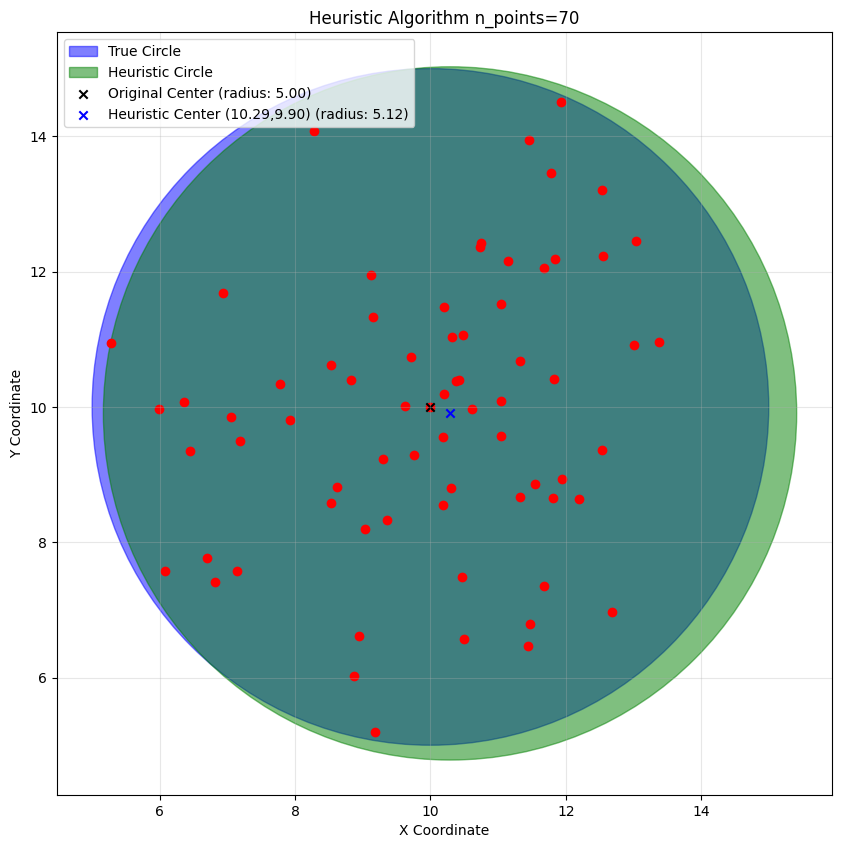

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

circle_patch = plt.Circle(
    (possible_circle.center_x, possible_circle.center_y),
    possible_circle.radius,
    color='blue',
    alpha=0.5,
    label="True Circle"
)
heuristic_patch = plt.Circle(
    (heuristic_circle.center_x, heuristic_circle.center_y),
    heuristic_circle.radius,
    color='green',
    alpha=0.5,
    label="Heuristic Circle"
)

ax.add_patch(circle_patch)
ax.add_patch(heuristic_patch)

if data is not None:
    x_coords = [point.x_coordinate for point in data]
    y_coords = [point.y_coordinate for point in data]
    ax.scatter(x_coords, y_coords, color='red')

ax.scatter(
    x=possible_circle.center_x,
    y=possible_circle.center_y,
    color='black',
    marker='x',
    label=f"Original Center (radius: {possible_circle.radius:.2f})"
)
heuristic_center_label = (
    f"Heuristic Center ({heuristic_circle.center_x:.2f},"
    f"{heuristic_circle.center_y:.2f}) (radius: {heuristic_circle.radius:.2f})"
)
ax.scatter(
    x=heuristic_circle.center_x,
    y=heuristic_circle.center_y,
    color='blue',
    marker='x',
    label=heuristic_center_label
)

ax.set_aspect('equal', adjustable='box')

plt.title(f"Heuristic Algorithm n_points={n_simulation_points}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

## Minimum Circle Algorithm

For the implementation of the minimum circle algorithm, we know that:

- It results on the minimum circle;
- Should take more time than the heuristic algorithm; and
- Although its implementation is more complex, it has the same $O(n)$ time complexity.

We used a simple Python function for the heuristic algorithm, but for the Minimum Circle Algorithm, we decided to use the a Python class, since multiple helper functions are needed, and they're better encapsulated in a class. The external API for the user will be a single `solve` method.

In [8]:
class MinCircle:
    """
    Minimum enclosing circle.

    Incrementally random algorithm to find the minimum circle in O(n) time
    complexity.

    Parameters
        rng (np.random.Generator | None): Random number generator to ensure
            reproducibility. If None, a new generator will be created.
    """

    def __init__(self, rng: np.random.Generator | None = None) -> None:
        self.rng = rng or np.random.default_rng()

    def _is_inside_helper(self, circle: Circle, point: Point) -> bool:
        """Simple helper to check if point is inside of circle."""
        return math.hypot(
            point.x_coordinate - circle.center_x,
            point.y_coordinate - circle.center_y
        ) <= circle.radius

    def _circle_with_two_points(
        self,
        p1: Point,
        p2: Point,
    ) -> Circle:
        """
        Base case for determining a circle with two points.

        The math is as follows:
            c = (p1 + p2)/2
            r = distance(p1, p2)/2

        Args:
            p1 (Point): The first point.
            p2 (Point): The second point.

        Returns:
            Circle: The circle defined by the two points.
        """

        center_x = (p1.x_coordinate + p2.x_coordinate) / 2.0
        center_y = (p1.y_coordinate + p2.y_coordinate) / 2.0
        radius = math.hypot(
            p1.x_coordinate - p2.x_coordinate,
            p1.y_coordinate - p2.y_coordinate
        ) / 2.0

        if radius <= 0:
            radius = 1e-12

        return Circle(
            center_x=center_x,
            center_y=center_y,
            radius=radius
        )

    def _circle_with_three_points(
        self,
        p1: Point,
        p2: Point,
        p3: Point,
    ) -> Circle:
        """
        Base case for determining a circle with three points.

        The math is as follows:
            c = found by the intersection of the perpendicular bisectors of
                the segments. To calculate that we do:
                    distance(p1, c)² = distance(p2, c)² = distance(p3, c)²
                and then solve the resulting equations.
            r = distance(c, p1)

        """

        d = 2.0 * (
            p1.x_coordinate * (p2.y_coordinate - p3.y_coordinate) +
            p2.x_coordinate * (p3.y_coordinate - p1.y_coordinate) +
            p3.x_coordinate * (p1.y_coordinate - p2.y_coordinate)
        )

        if abs(d) < 1e-12:
            # Collinear case
            pairs = [
                (p1, p2, distance_between_two_points(p1, p2)),
                (p1, p3, distance_between_two_points(p1, p3)),
                (p2, p3, distance_between_two_points(p2, p3)),
            ]
            a, b, _ = max(pairs, key=lambda t: t[2])
            return self._circle_with_two_points(a, b)

        x1s = p1.x_coordinate**2 + p1.y_coordinate**2
        x2s = p2.x_coordinate**2 + p2.y_coordinate**2
        x3s = p3.x_coordinate**2 + p3.y_coordinate**2
        y1, y2, y3 = p1.y_coordinate, p2.y_coordinate, p3.y_coordinate
        x1, x2, x3 = p1.x_coordinate, p2.x_coordinate, p3.x_coordinate

        # Classical formulas for finding the circumcenter
        ux = (x1s * (y2 - y3) + x2s * (y3 - y1) + x3s * (y1 - y2)) / d
        uy = (x1s * (x3 - x2) + x2s * (x1 - x3) + x3s * (x2 - x1)) / d

        return Circle(
            center_x=ux,
            center_y=uy,
            radius=math.hypot(ux - p1.x_coordinate, uy - p1.y_coordinate)
        )

    def _min_circle_with_point(
        self,
        points: list[Point],
        p: Point,
    ) -> Circle:

        if not points:
            return Circle(
                center_x=p.x_coordinate,
                center_y=p.y_coordinate,
                radius=1e-12
            )

        circle = self._circle_with_two_points(points[0], p)

        for j in range(1, len(points)):
            point_j = points[j]
            if not self._is_inside_helper(circle, point_j):
                circle = self._min_circle_with_two_points(
                    points=points[:j],
                    p1=point_j,
                    p2=p,
                )

        return circle

    def _min_circle_with_two_points(
        self,
        points: list[Point],
        p1: Point,
        p2: Point,
    ) -> Circle:

        circle = self._circle_with_two_points(p1, p2)

        for k in range(len(points)):
            point_k = points[k]
            if not self._is_inside_helper(circle, point_k):
                circle = self._circle_with_three_points(p1, p2, point_k)

        return circle

    def _min_circle(self, points: list[Point]) -> Circle:

        copy_points = list(points)
        self.rng.shuffle(copy_points)

        if len(copy_points) == 1:
            first_point = copy_points[0]
            return Circle(
                center_x=first_point.x_coordinate,
                center_y=first_point.y_coordinate,
                radius=1e-12
            )

        circle = self._circle_with_two_points(
            copy_points[0],
            copy_points[1]
        )

        for i in range(2, len(copy_points)):
            point_i = copy_points[i]
            if not self._is_inside_helper(circle, point_i):
                circle = self._min_circle_with_point(copy_points[:i], point_i)

        return circle

    def solve(self, points: list[Point]) -> Circle:
        return self._min_circle(points)

In [9]:
min_circle_algorithm = MinCircle()
min_circle_result = min_circle_algorithm.solve(points=data)
min_circle_result

Circle(center_x=10.058960899880685, center_y=9.995056889291236, radius=4.879126656884018)

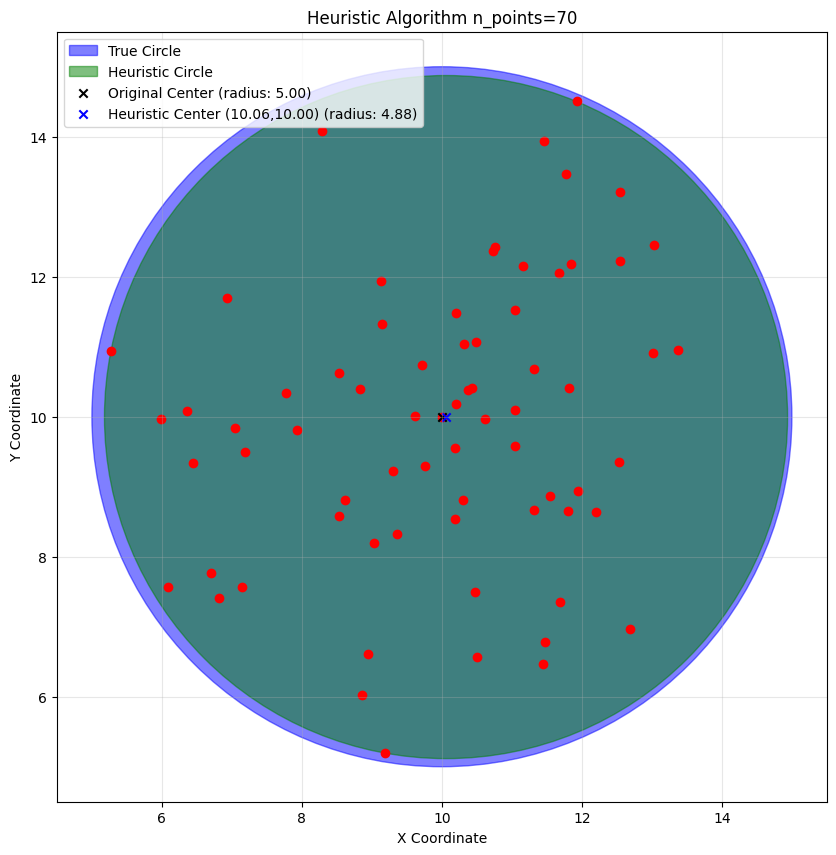

In [10]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

circle_patch = plt.Circle(
    (possible_circle.center_x, possible_circle.center_y),
    possible_circle.radius,
    color='blue',
    alpha=0.5,
    label="True Circle"
)
min_circle_patch = plt.Circle(
    (min_circle_result.center_x, min_circle_result.center_y),
    min_circle_result.radius,
    color='green',
    alpha=0.5,
    label="Heuristic Circle"
)

ax.add_patch(circle_patch)
ax.add_patch(min_circle_patch)

if data is not None:
    x_coords = [point.x_coordinate for point in data]
    y_coords = [point.y_coordinate for point in data]
    ax.scatter(x_coords, y_coords, color='red')

ax.scatter(
    x=possible_circle.center_x,
    y=possible_circle.center_y,
    color='black',
    marker='x',
    label=f"Original Center (radius: {possible_circle.radius:.2f})"
)
heuristic_center_label = (
    f"Heuristic Center ({min_circle_result.center_x:.2f},"
    f"{min_circle_result.center_y:.2f}) (radius: {min_circle_result.radius:.2f})"
)
ax.scatter(
    x=min_circle_result.center_x,
    y=min_circle_result.center_y,
    color='blue',
    marker='x',
    label=heuristic_center_label
)

ax.set_aspect('equal', adjustable='box')

plt.title(f"Heuristic Algorithm n_points={n_simulation_points}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

## Simulations to ensure O(n) time complexity

To ensure that both algorithms have $O(n)$ time complexity, we can run simulations with varying numbers of points and measure the execution time for each algorithm.

We created 2 classes for configuring our simulation:
- `SimulationStep`: Represents a single simulation step, including the number of points, the circle, and the results from both algorithms.
- `SimulationConfig`: Represents a list of all simulation steps.

Then, created 2 functions to run the simulations:
- `_run_one_heuristic`: Runs the heuristic algorithm for a given simulation step and measures its execution time.
- `_run_one_min_circle`: Runs the minimum circle algorithm for a given simulation step and measures its execution time.

Finally, we leverage Python's `multiprocessing` library to run the simulations in parallel, improving performance with the `run_parallel_simulation` function (we also have a sequential version, `run_sequential_simulation`, for comparison).

We create a fixed `Circle` with center at `(0, 0)` and radius `100`, then generate a cloud of `n` randomized points inside this circle for each simulation step. We run both algorithms on these points and store the execution time for each algorithm in each step.

In [11]:
class SimulationStep(BaseModel):
    simulation_id: int
    circle: Circle
    n_points: int
    time_to_execute: float | None = None

    def points_and_time_in_ms(self) -> tuple[int, float]:
        if self.time_to_execute is None:
            raise ValueError("Time to execute is not yet set!")
        return self.n_points, self.time_to_execute * 1000

class SimulationConfig(BaseModel):
    simulations: list[SimulationStep]

circle_simulation = Circle(
    center_x=0,
    center_y=0,
    radius=100,
)

all_simulations = []
number_of_simulations = 200
for i in range(1, number_of_simulations+1):
    step = SimulationStep(
        simulation_id=i,
        circle=circle_simulation,
        n_points=100*i,
    )
    all_simulations.append(step)

SIMULATION_RNG_ID = 1

config = SimulationConfig(
    simulations=all_simulations
)

In [12]:
from collections.abc import Callable
from multiprocessing import Pool, cpu_count
from time import perf_counter


def _run_one_heuristic(step: SimulationStep) -> SimulationStep:

    rng = np.random.default_rng(SIMULATION_RNG_ID)

    simulation = CircleSimulationData(circle=step.circle, rng=rng)
    data = simulation.generate_point_cloud(n_points=step.n_points)

    start = perf_counter()
    heuristic_algorithm(data)
    end = perf_counter()

    step.time_to_execute = end - start
    return step

def _run_one_min_circle(step: SimulationStep) -> SimulationStep:

    rng = np.random.default_rng(SIMULATION_RNG_ID)

    simulation = CircleSimulationData(circle=step.circle, rng=rng)
    data = simulation.generate_point_cloud(n_points=step.n_points)

    min_circle_algorithm = MinCircle(rng=rng)

    start = perf_counter()
    min_circle_algorithm.solve(data)
    end = perf_counter()

    step.time_to_execute = end - start
    return step


MAX_ALLOWED_CONCURRENT_PROCESSES = int(cpu_count())//2

def run_parallel_simulation(
    config: SimulationConfig,
    run_fn: Callable[[SimulationStep], SimulationStep],
    ) -> SimulationConfig:
    with Pool(processes=MAX_ALLOWED_CONCURRENT_PROCESSES) as pool:
        results = pool.map(run_fn, config.simulations)
    config.simulations = results
    return config

def run_sequential_simulation(
    config: SimulationConfig,
    run_fn: Callable[[SimulationStep], SimulationStep],
) -> SimulationConfig:
    results = []
    for step in config.simulations:
        result = run_fn(step)
        results.append(result)
    config.simulations = results
    return config

In [13]:
results_heuristic = run_parallel_simulation(
    config=SimulationConfig(simulations=all_simulations),
    run_fn=_run_one_heuristic,
)
results_min_circle = run_parallel_simulation(
    config=SimulationConfig(simulations=all_simulations),
    run_fn=_run_one_min_circle,
)

In [14]:
# results_sequential_heuristic = run_sequential_simulation(config=config, run_fn=_run_one_heuristic)
# results_sequential_min_circle = run_sequential_simulation(config=config, run_fn=_run_one_min_circle)

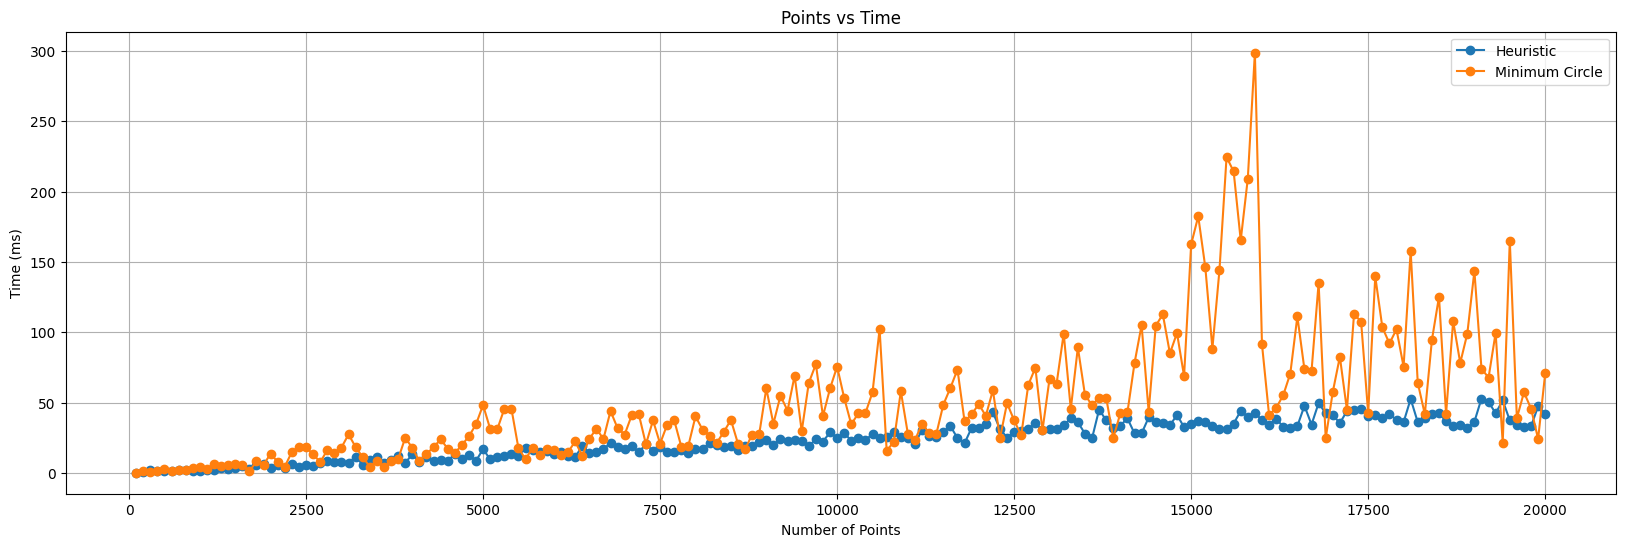

In [15]:
points_h, points_m = [], []
time_h, time_m = [], []

for result in results_heuristic.simulations:
    # print(result.points_and_time_in_ms())
    points_h.append(result.points_and_time_in_ms()[0])
    time_h.append(result.points_and_time_in_ms()[1])

for result in results_min_circle.simulations:
    # print(result.points_and_time_in_ms())
    points_m.append(result.points_and_time_in_ms()[0])
    time_m.append(result.points_and_time_in_ms()[1])

plt.figure(figsize=(20, 6))

plt.plot(points_h, time_h, marker='o', label='Heuristic')
plt.plot(points_m, time_m, marker='o', label='Minimum Circle')

plt.title("Points vs Time")
plt.xlabel("Number of Points")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid()
plt.show()

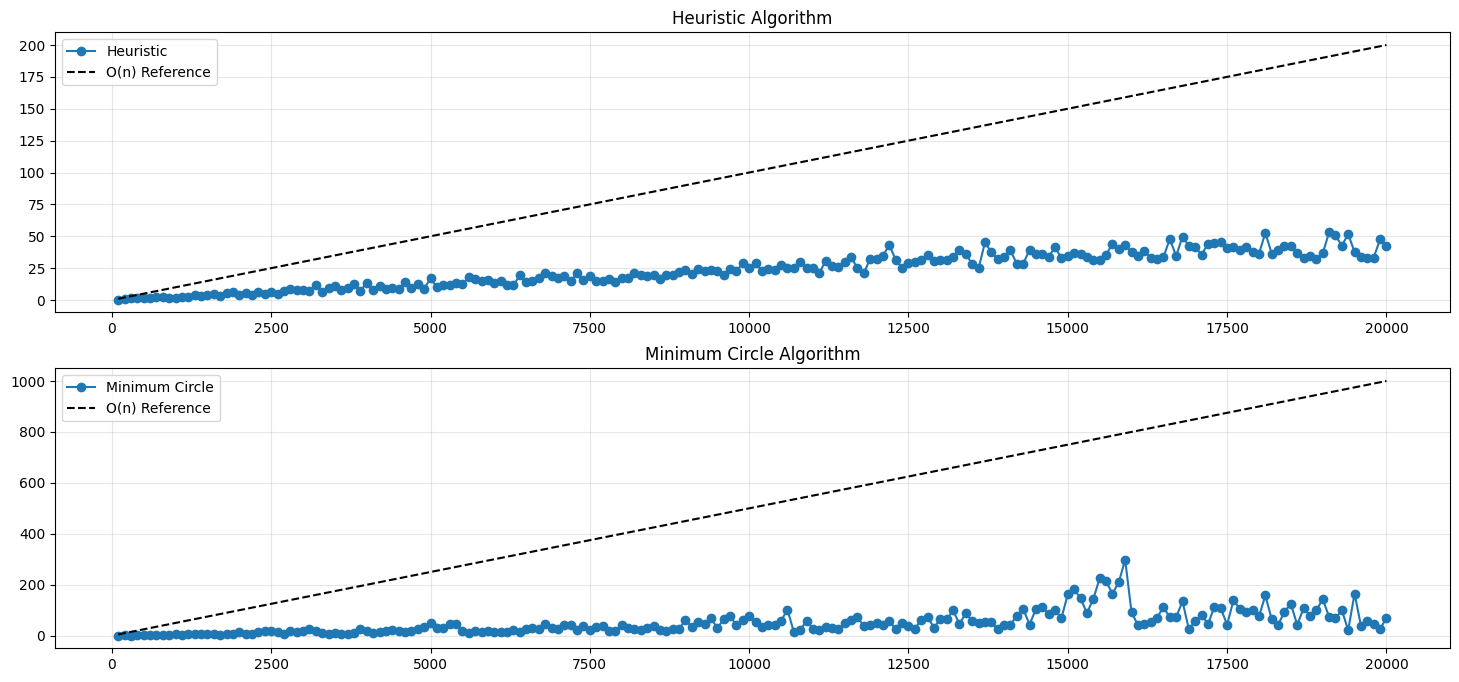

<Figure size 640x480 with 0 Axes>

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(18, 8))

ax[0].plot(points_h, time_h, marker='o', label='Heuristic')
ax[0].plot(points_h, [0.01 * n for n in points_h], linestyle='--', color='black', label='O(n) Reference')
ax[0].set_title("Heuristic Algorithm")
ax[0].grid(alpha=0.3)
ax[0].legend(loc='upper left')

ax[1].plot(points_m, time_m, marker='o', label='Minimum Circle')
ax[1].plot(points_h, [0.05 * n for n in points_h], linestyle='--', color='black', label='O(n) Reference')
ax[1].set_title("Minimum Circle Algorithm")
ax[1].grid(alpha=0.3)
ax[1].legend(loc='upper left')

plt.show()
plt.tight_layout()